# WASP-121

In [1]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
name = 'WASP-121'

In [3]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))

In [4]:
len(fnames)

1155

In [5]:
obs = om.Observation.from_files(fnames)

/Users/ch/HST/projects/ombre/src/ombre/visit.py:208: RuntimeWarning: divide by zero encountered in true_divide
  w[self.err / self.sci > 0.1] = 1e10


In [6]:
obs

WASP-121 [6 Visits]

In [7]:
clc = lk.search_lightcurve(name, author='SPOC', exptime=120).download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

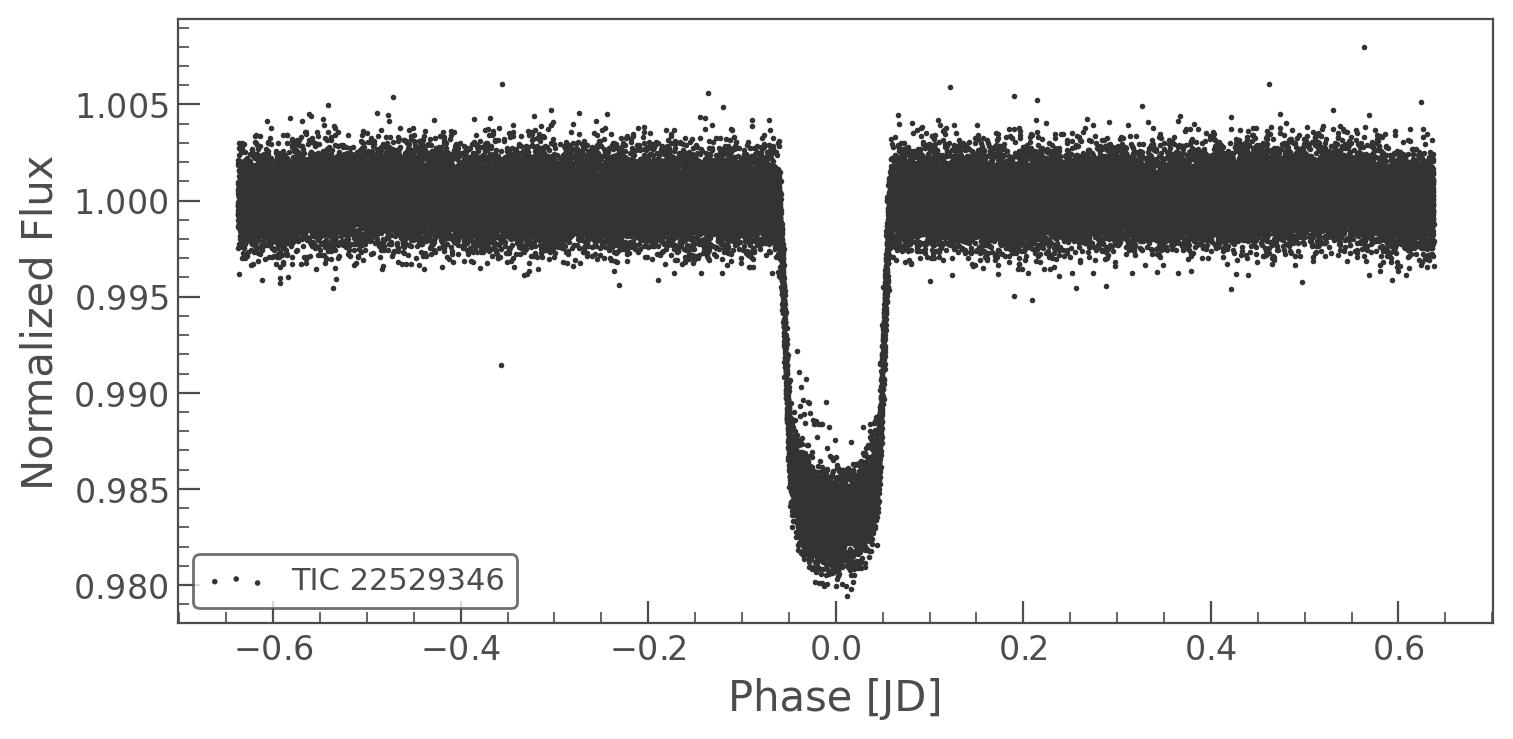

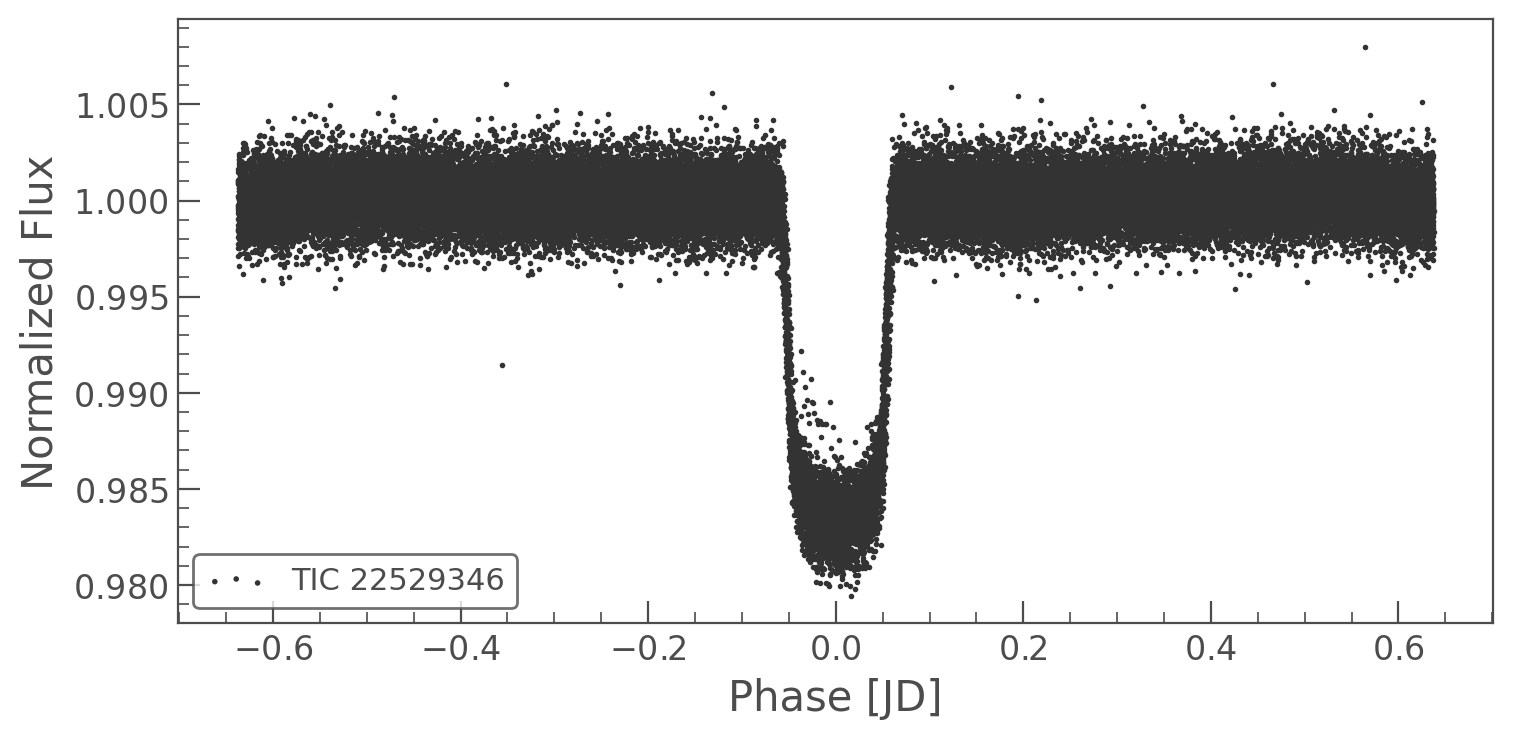

In [8]:
clc.fold(obs.period, obs.t0 - 2457000).scatter()

bls = clc.to_periodogram('bls', minimum_period=obs.period * 0.99, maximum_period=obs.period * 1.01, duration=obs.duration/24, frequency_factor=10)
obs.period, obs.t0 = bls.period_at_max_power.value, bls.transit_time_at_max_power.value + 2457000

clc.fold(obs.period, obs.t0 - 2457000).scatter()

In [9]:
obs.fit_transit(x_suppl=clc.time.value + 2457000,
                y_suppl=clc.flux.value,
                yerr_suppl=clc.flux_err.value,
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

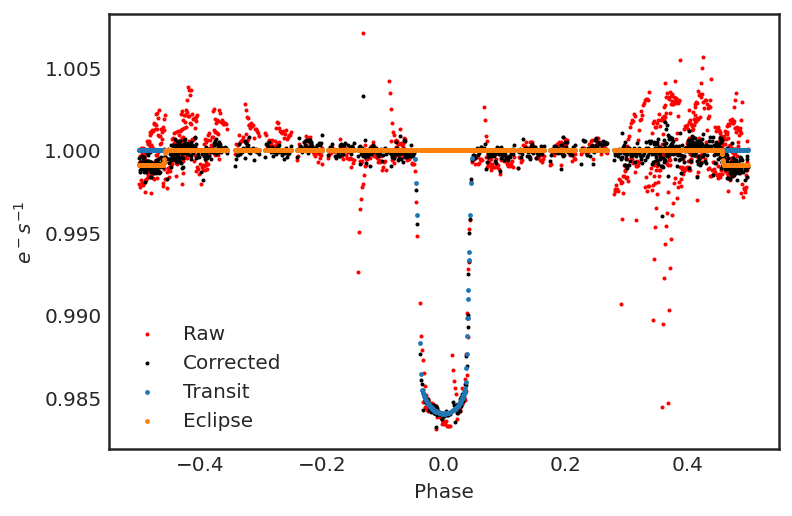

In [10]:
obs.plot()

In [11]:
obs.fit_model()

Fitting Transit/Eclipse Model:   0%|          | 0/6 [00:00<?, ?it/s]

Fitting Transit/Eclipse Model:  17%|█▋        | 1/6 [00:21<01:48, 21.73s/it]

Fitting Transit/Eclipse Model:  33%|███▎      | 2/6 [00:41<01:22, 20.56s/it]

Fitting Transit/Eclipse Model:  50%|█████     | 3/6 [00:54<00:51, 17.17s/it]

Fitting Transit/Eclipse Model:  67%|██████▋   | 4/6 [01:08<00:31, 15.71s/it]

Fitting Transit/Eclipse Model:  83%|████████▎ | 5/6 [02:19<00:35, 35.66s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 6/6 [03:20<00:00, 44.35s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 6/6 [03:20<00:00, 33.39s/it]

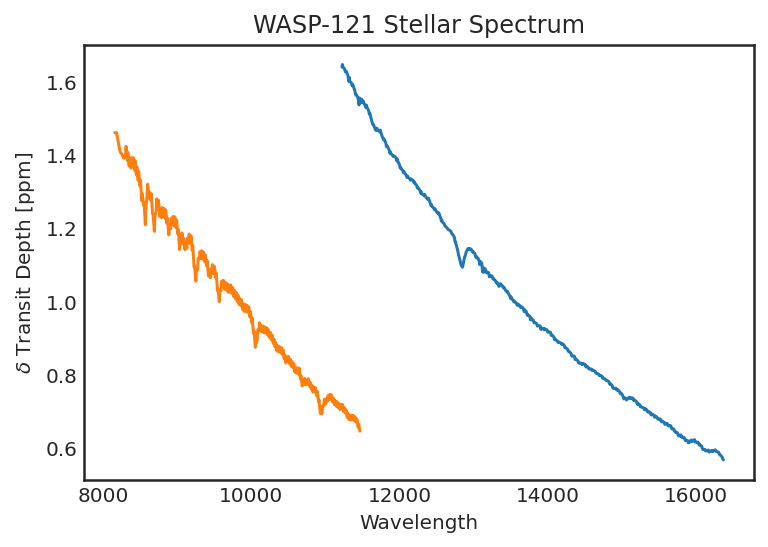

In [12]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

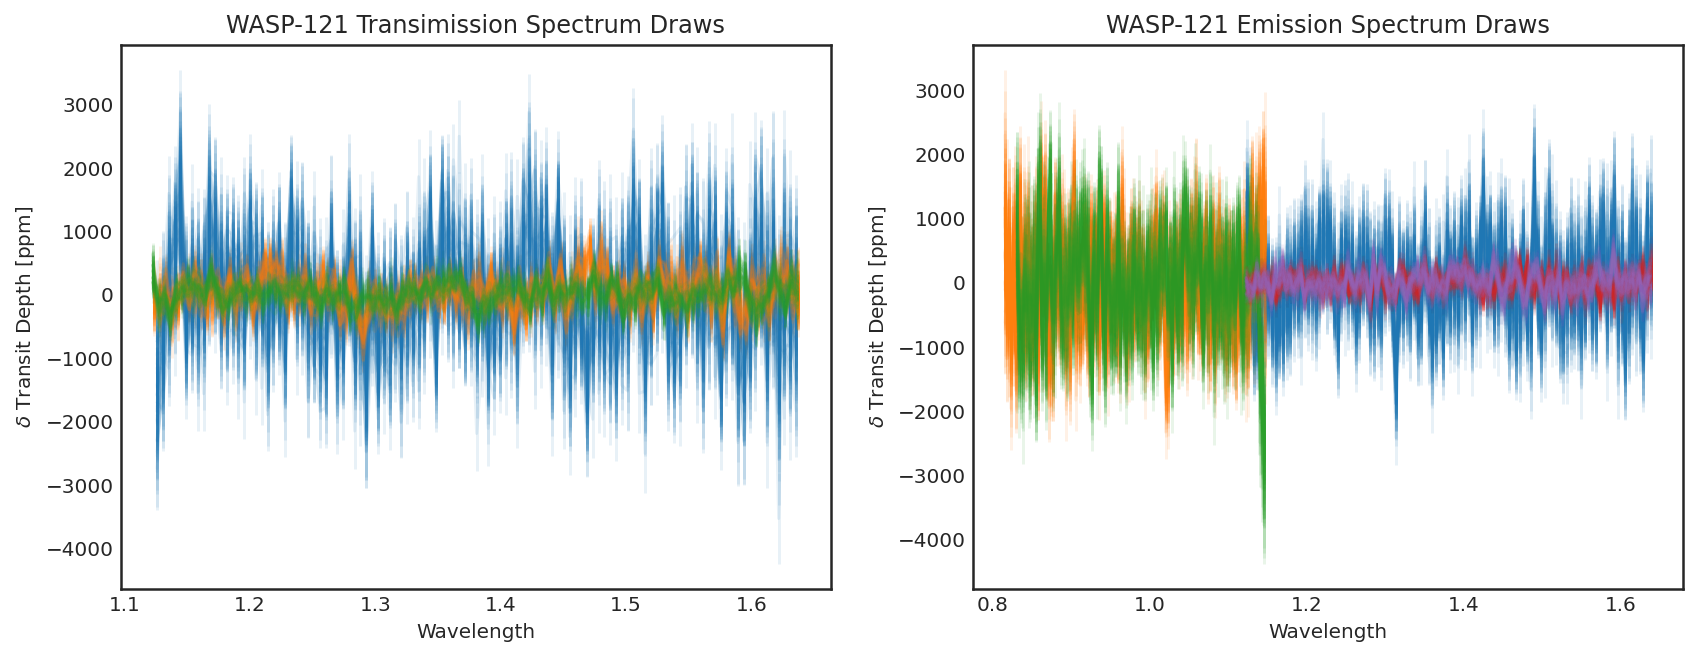

In [13]:
obs.plot_spectra()

[Text(0.5, 1.0, 'WASP-107 Transmission Spectrum')]

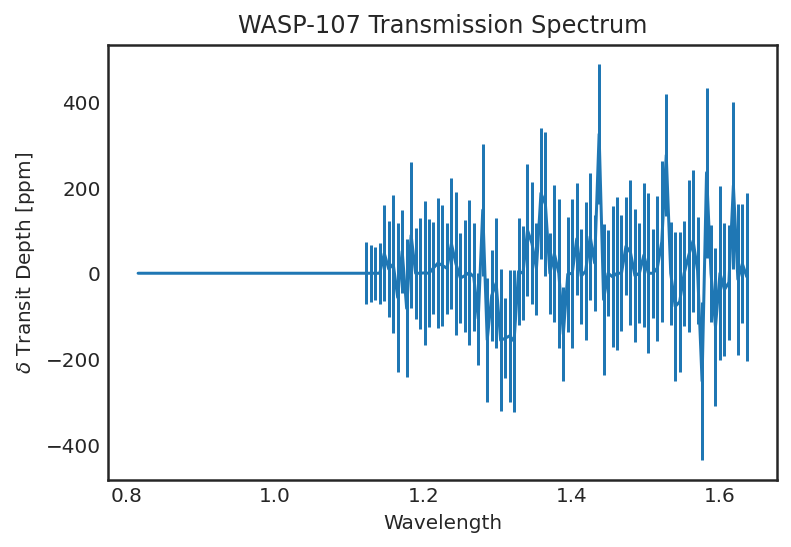

In [14]:
ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
ax.set(title='WASP-107 Transmission Spectrum')

In [15]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

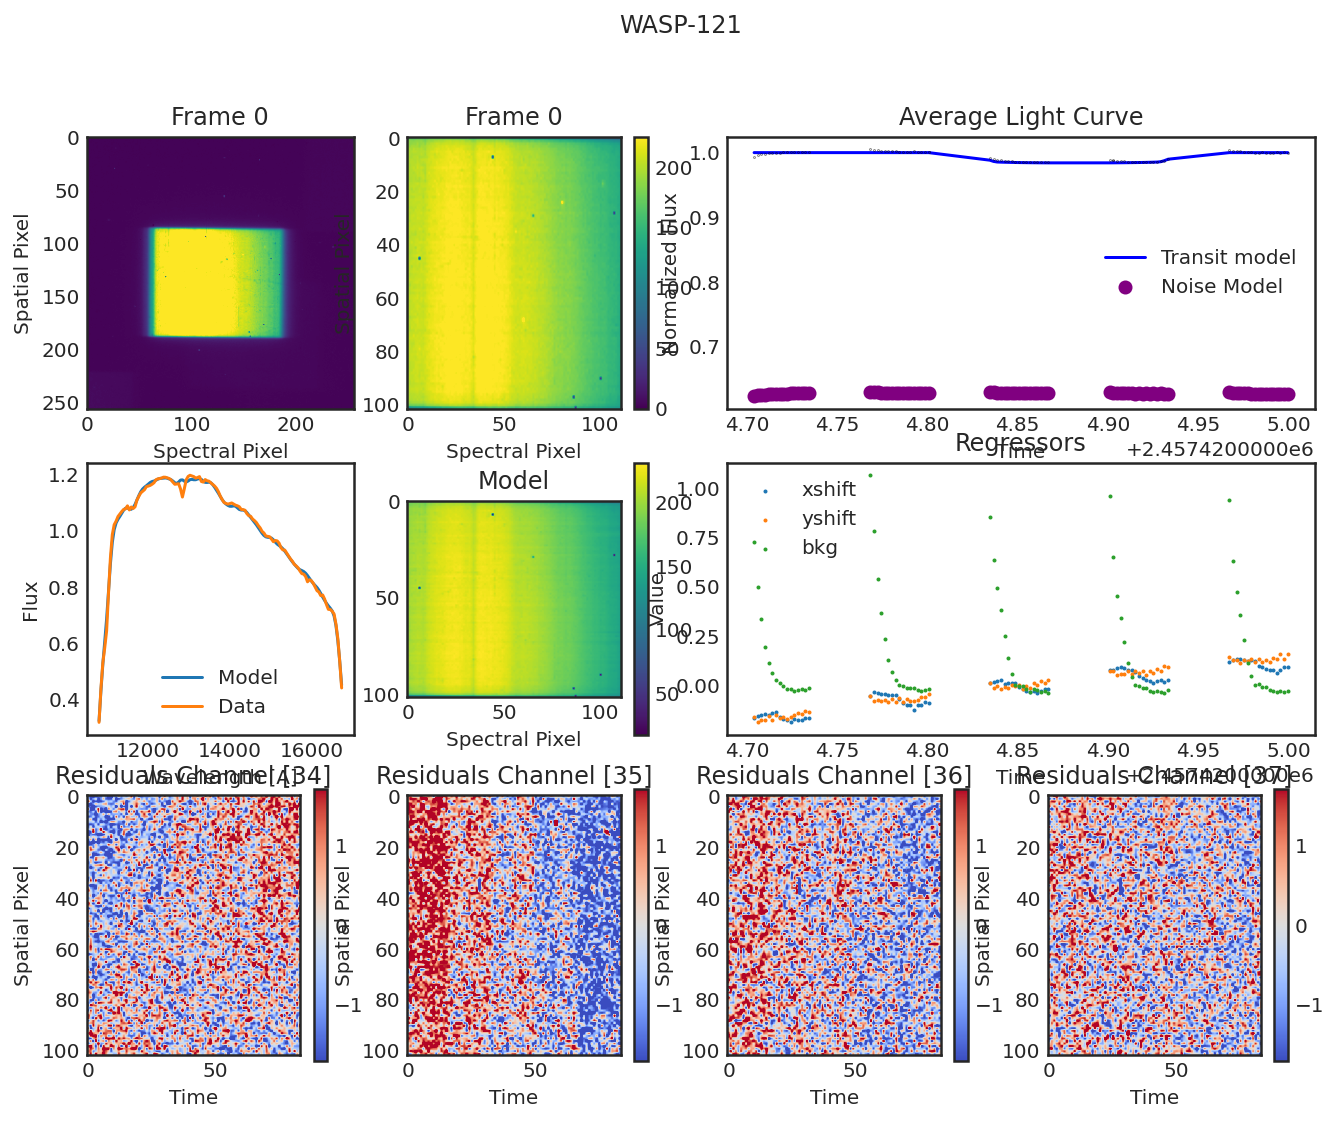

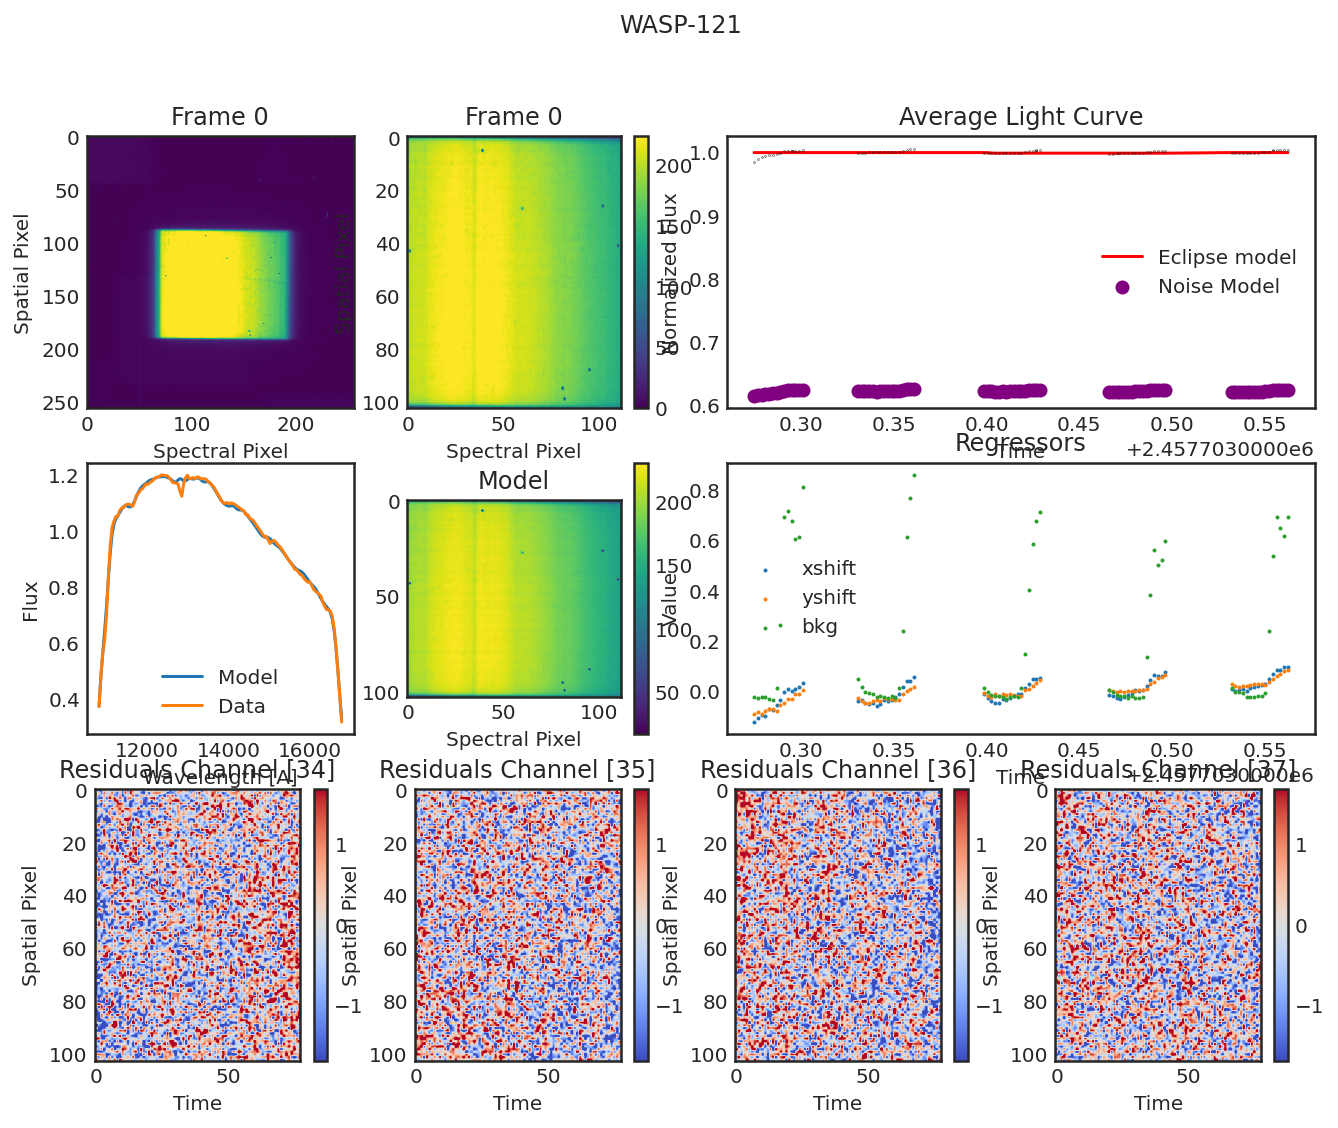

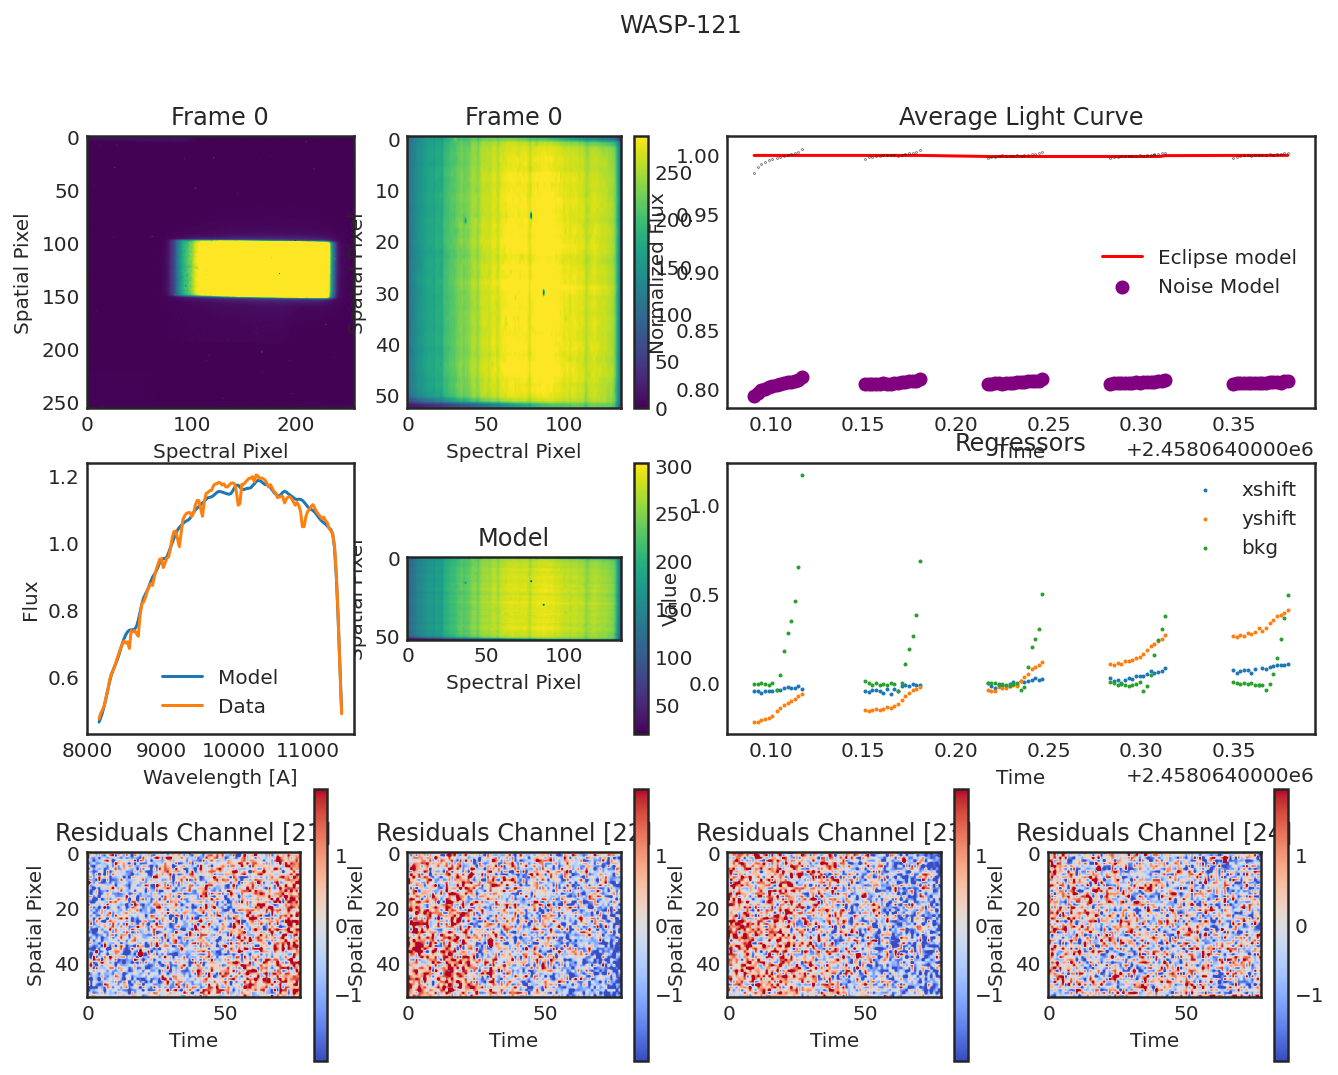

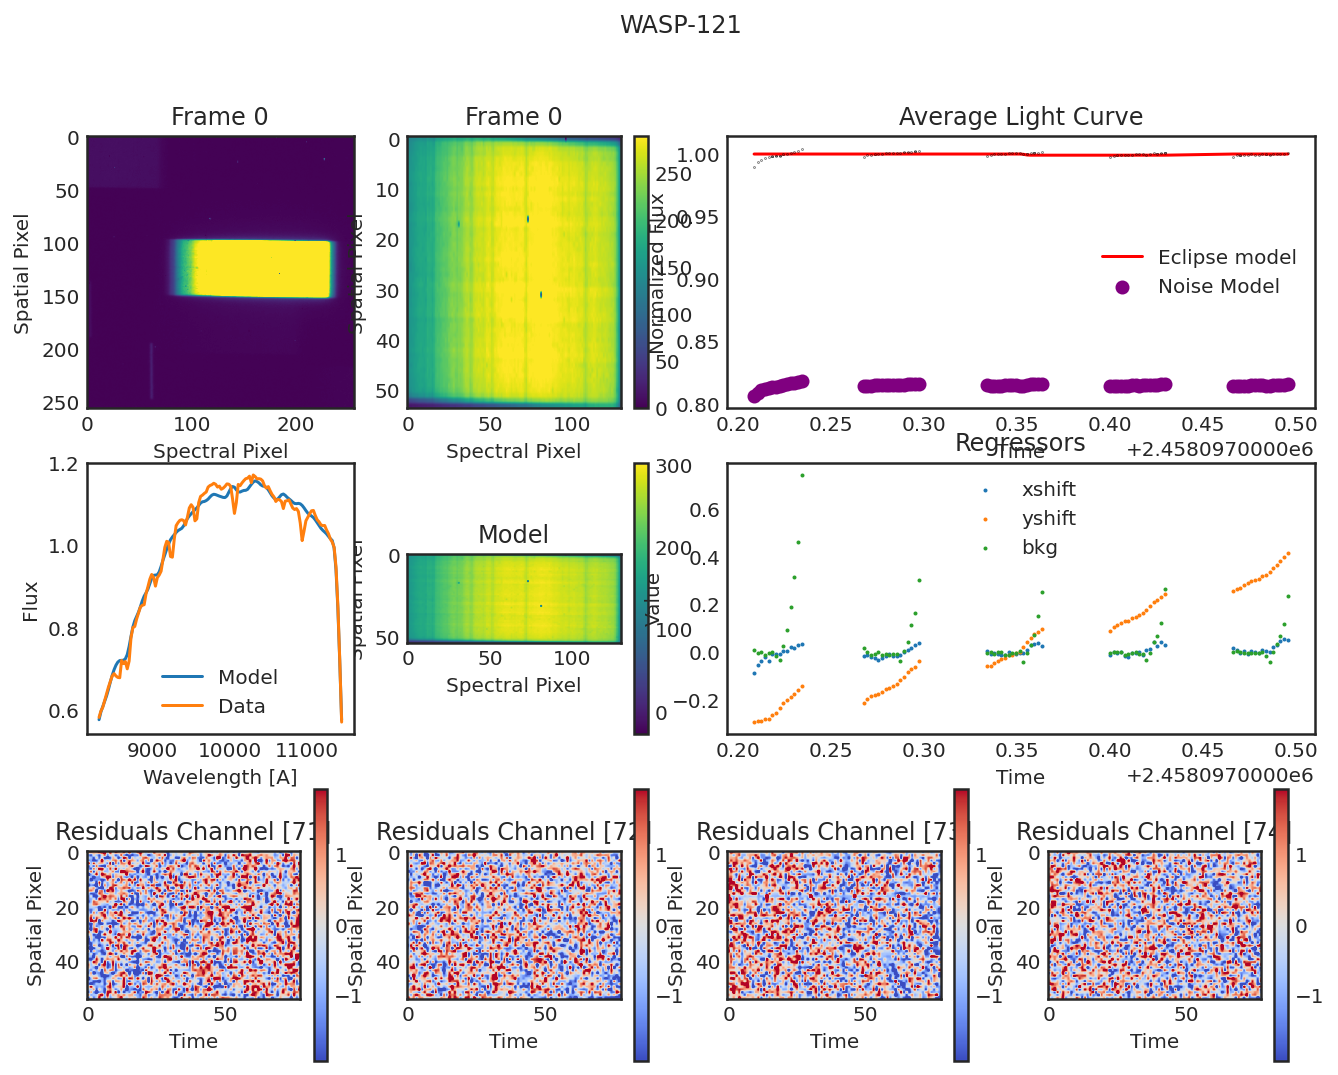

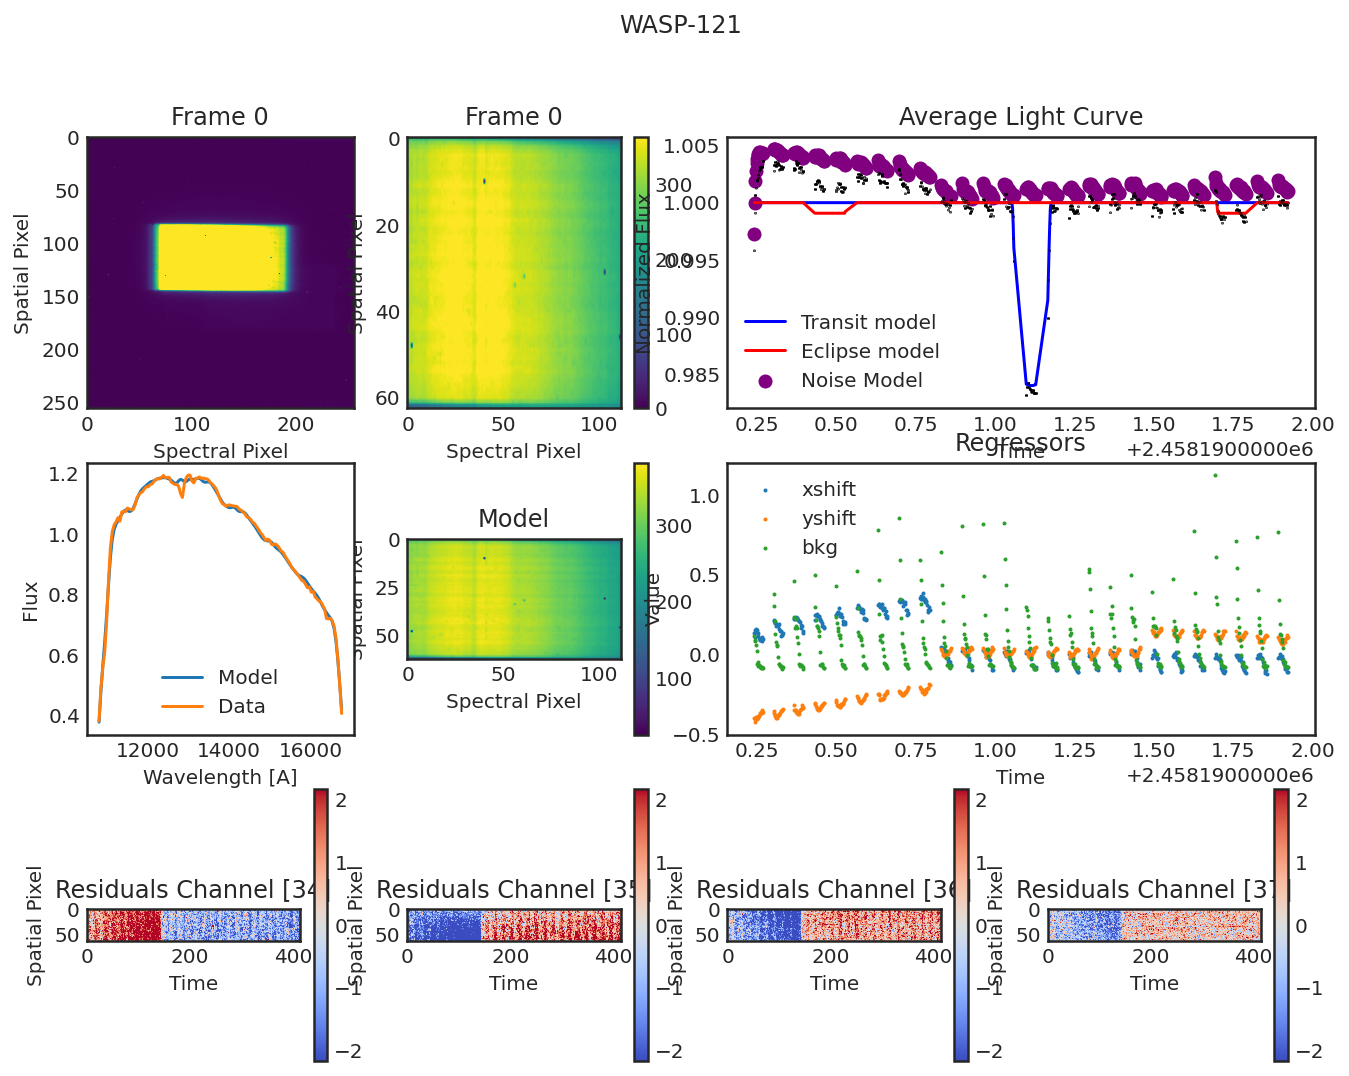

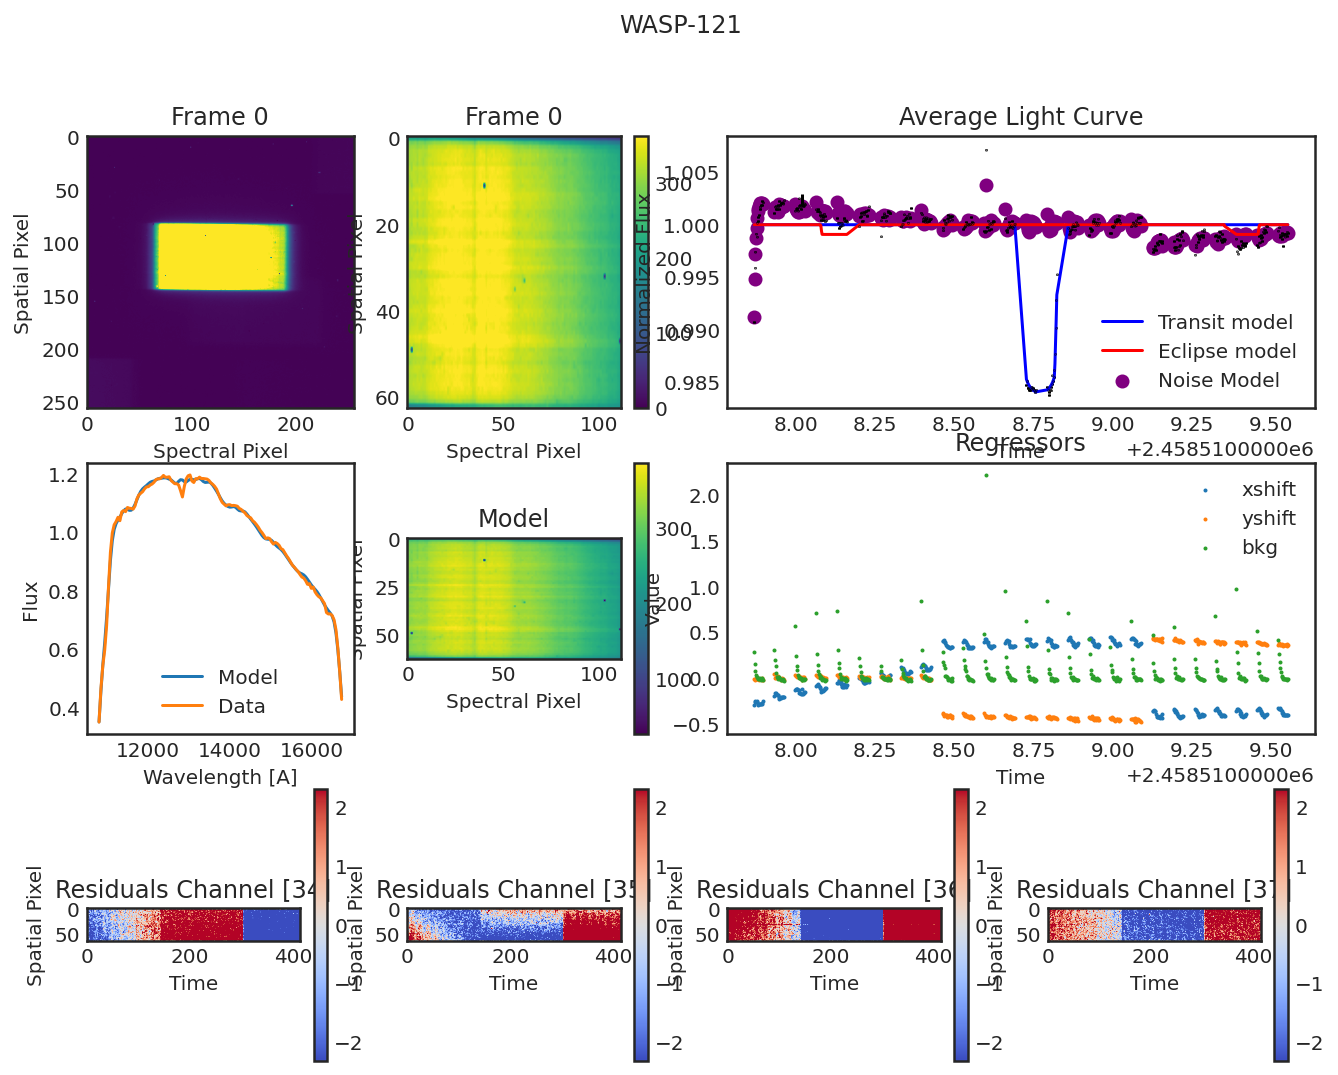

In [16]:
for visit in obs:
    visit.diagnose();
    plt.show();